# Insurance Claim Prediction

### CAS Introduction to Machine Learning in Finance and Insurance (Spring 2025)
#### Navarro Diego - <href>dnavarro@ethz.ch</href>
#### Rizzi Michele - <href>mirizzi@ethz.ch</href>
#### Hrovatin Lucia - <href>lhrovatin@ethz.ch</href>

## 1. Initial Setup

In [36]:
### Import all the Python libraries you are going to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
import keras_tuner as kt
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.losses import Poisson

In [37]:
### Fix random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## 2. Poisson GLM.

### 2.1. Data load and feature calculation

In [38]:
import os 
cd = os.getcwd()
df = pd.read_csv(f'{cd}/freMTPL2freq.csv', sep = ";", decimal = ",")
# Read csv file

# Compute frequency
df['freq'] = df['ClaimNb'] / df['Exposure']

### 2.2 Descriptive Statistics

In [39]:
# Descriptive statistics
desc = df.describe(include='all').T
medians = df.median(numeric_only=True)

# Add median to the summary table
desc['median'] = medians

# Add a column with the data format (dtype) for each feature
desc['dtype'] = df.dtypes

# Show formatted table
desc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,median,dtype
VehPower,678007.0,NaN,NaN,NaN,6.454653,2.050902,4.0,5.0,6.0,7.0,15.0,6.00,int64
VehAge,678007.0,NaN,NaN,NaN,7.044218,5.666235,0.0,2.0,6.0,11.0,100.0,6.00,int64
DrivAge,678007.0,NaN,NaN,NaN,45.499061,14.137492,18.0,34.0,44.0,55.0,100.0,44.00,int64
BonusMalus,678007.0,NaN,NaN,NaN,59.761588,15.6367,50.0,50.0,50.0,64.0,230.0,50.00,int64
VehBrand,678007,11,B12,166024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
VehGas,678007,2,Regular,345871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
Density,678007.0,NaN,NaN,NaN,1792.430975,3958.663031,1.0,92.0,393.0,1658.0,27000.0,393.00,int64
Region,678007,22,R24,160601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
Exposure,678007.0,NaN,NaN,NaN,0.528547,0.364081,0.002732,0.18,0.49,0.99,1.0,0.49,float64
ClaimNb,678007.0,NaN,NaN,NaN,0.038913,0.204752,0.0,0.0,0.0,0.0,5.0,0.00,int64


### 2.3 Exploratory visualizations

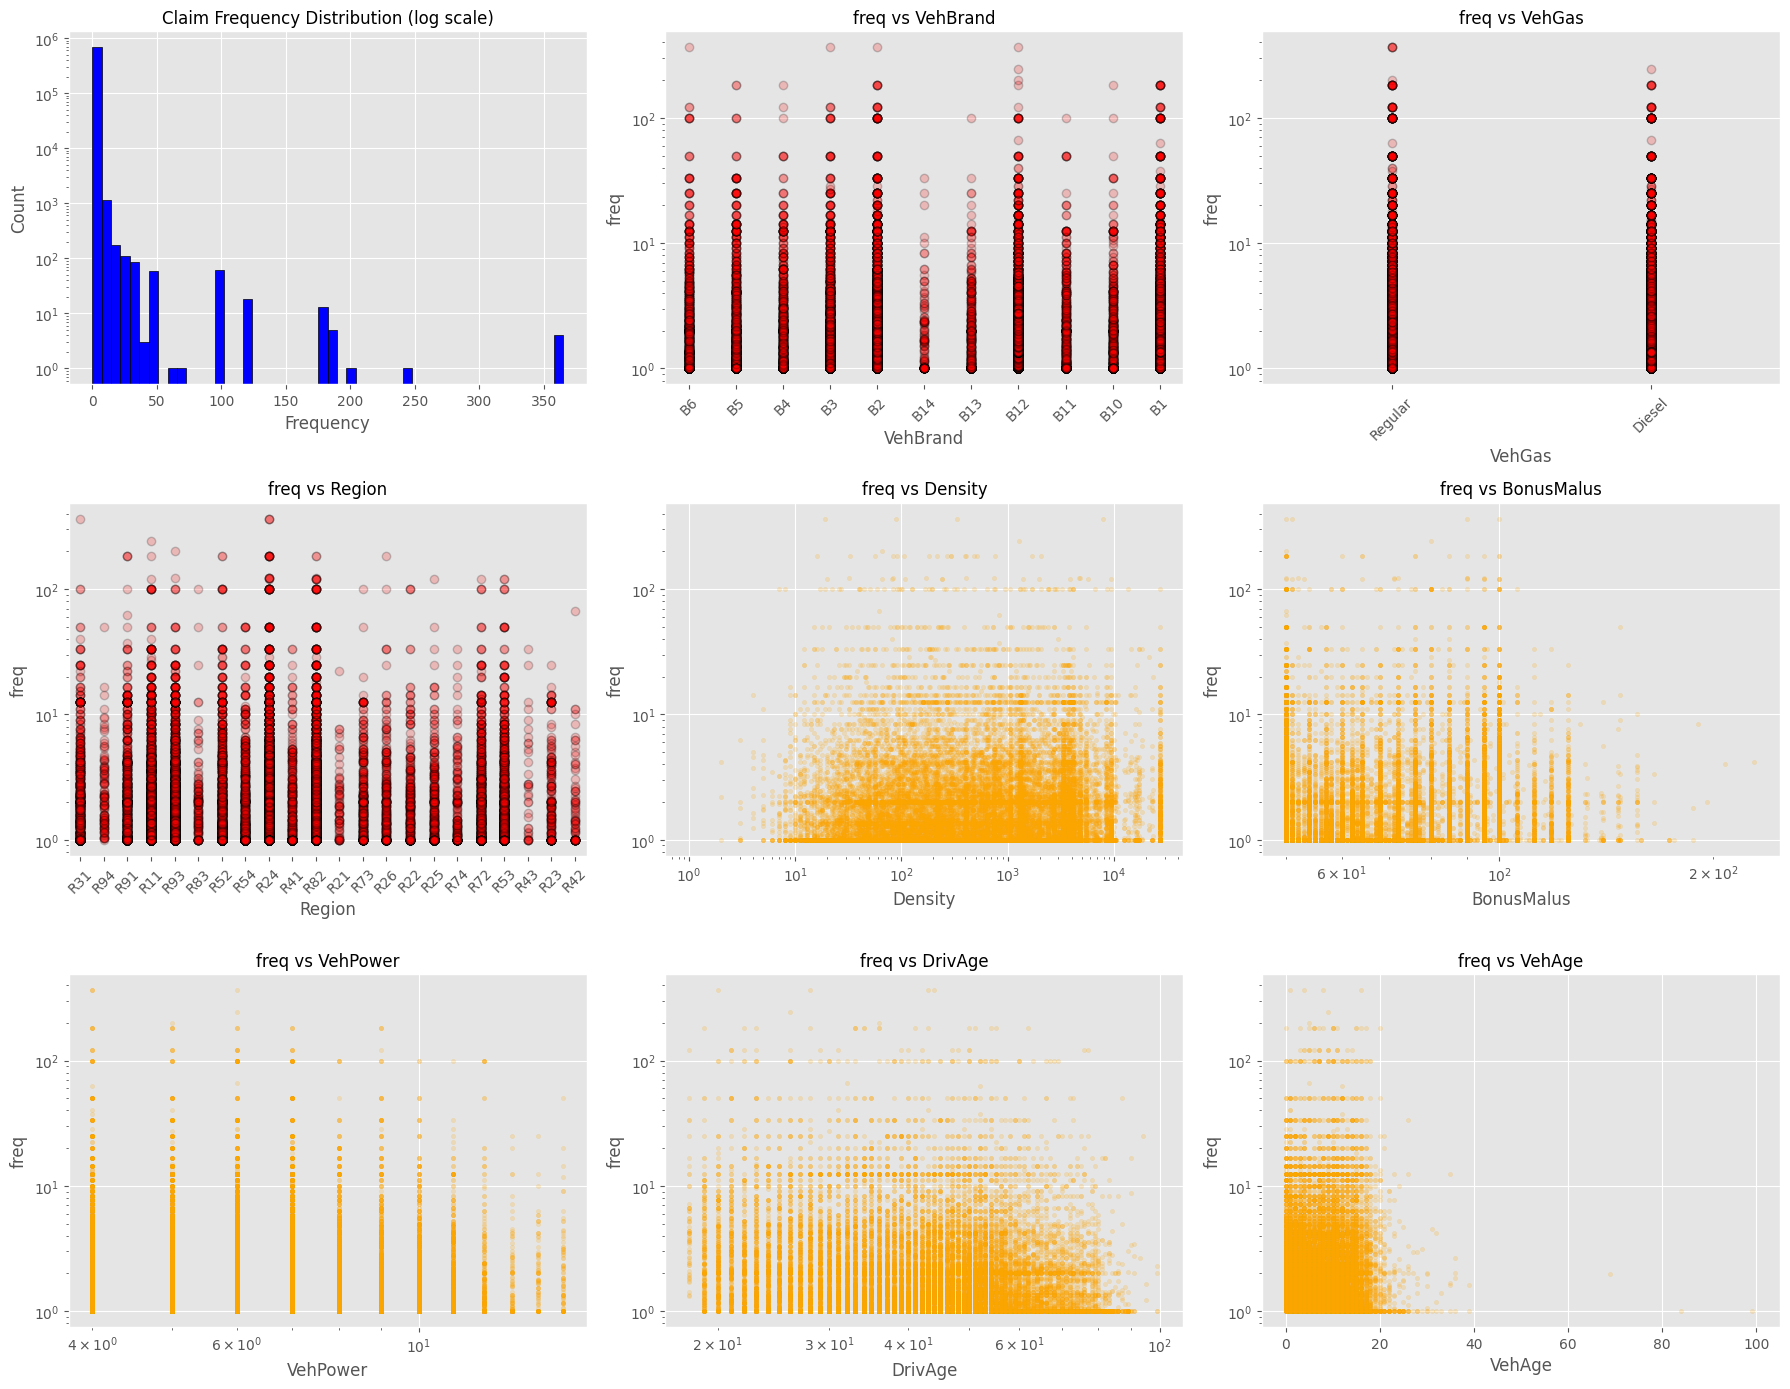

In [40]:
plt.style.use('ggplot')
color_hist = 'blue'
color_box = 'red'
color_scatter = 'orange'

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# Histogram of freq
ax = axes[0]
df['freq'].hist(bins=50, ax=ax, color=color_hist, edgecolor='black')
ax.set_yscale('log')
ax.set_title('Claim Frequency Distribution (log scale)', fontsize=12)
ax.set_xlabel('Frequency')
ax.set_ylabel('Count')

# Boxplots for categorical features
groups = ['VehBrand', 'VehGas', 'Region']
for idx, col in enumerate(groups, start=1):
    ax = axes[idx]
    sns.boxplot(x=col, y='freq', data=df, ax=ax, color=color_box,
                flierprops=dict(marker='o', markerfacecolor='red', markeredgecolor=None, alpha = 0.2))
    ax.set_yscale('log')
    ax.set_title(f'freq vs {col}', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('freq')
    ax.tick_params(axis='x', rotation=45)

# Scatter plots for continuous variables
conts = ['Density', 'BonusMalus', 'VehPower', 'DrivAge', 'VehAge']
for idx, col in enumerate(conts, start=4):
    ax = axes[idx]
    sns.scatterplot(x=df[col], y=df['freq'], ax=ax, color=color_scatter, alpha=0.2, edgecolor=None, s=10)
    if df[col].min() > 0:
        ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(col)
    ax.set_ylabel('freq')
    ax.set_title(f'freq vs {col}', fontsize=12)

# Hide any unused subplot axes
for j in range(len(groups) + len(conts) + 1, len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
plt.show()

### 2.4 Pre-Process Features

In [41]:
# Bin VehAge
df['VehAge_bin'] = pd.cut(df['VehAge'], bins=[0,6,13,np.inf], labels=['0-5','6-12','13+'])

# Log transforms
df['ln_VehPower'] = np.log(df['VehPower'])
df['ln_DrivAge']  = np.log(df['DrivAge'])
df['ln_BM']       = np.log(df['BonusMalus'])
df['ln_Density']  = np.log(df['Density'])

# Define features and sample weights
y = df['freq']
sample_weight = df['Exposure']

numeric_features = ['ln_VehPower','ln_DrivAge','DrivAge', 'ln_BM','ln_Density']
categorical_features = ['VehBrand','VehGas','Region','VehAge_bin']

### 2.5 Train-Test Split

In [42]:
X = df[numeric_features + categorical_features]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weight, test_size=0.1, random_state=random_seed
)

### 2.6 Train Poisson GLM

In [43]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

glm = Pipeline(steps=[
    ('pre', preprocessor),
    ('glm', PoissonRegressor(alpha=0.0, max_iter=1000))
])
glm.fit(X_train, y_train, glm__sample_weight=w_train)

y_pred_train = glm.predict(X_train)
y_pred_test  = glm.predict(X_test)

### 2.7 Train Poisson GLM with Interaction Features

In [44]:
def add_interactions(X_df):
    df_int = X_df.copy()
    df_int['DrivAge2'] = df_int['DrivAge']**2
    df_int['BMxDA']    = df_int['ln_BM'] * df_int['DrivAge']
    df_int['BMxDA2']   = df_int['ln_BM'] * df_int['DrivAge2']
    return df_int

X_train_int = add_interactions(X_train)
X_test_int  = add_interactions(X_test)

numeric_int = numeric_features + ['DrivAge2','BMxDA','BMxDA2']

preprocessor_int = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_int),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

glm_int = Pipeline(steps=[
    ('pre', preprocessor_int),
    ('glm', PoissonRegressor(alpha=0.0, max_iter=1000))
])
glm_int.fit(X_train_int, y_train, glm__sample_weight=w_train)

y_pred_int_train = glm_int.predict(X_train_int)
y_pred_int_test = glm_int.predict(X_test_int)

### 2.8 Evaluate Results

In [45]:
def weighted_mae(y, y_pred, w):
    return np.average(np.abs(y - y_pred), weights=w)

def weighted_mse(y, y_pred, w):
    return np.average((y - y_pred)**2, weights=w)

def poisson_deviance(y, y_pred, w):
    return 1/np.sum(w)*np.sum(w*2*(y_pred-y*(1+np.log(y_pred)+np.log(y_pred))))

# GLM metrics
mae_train = weighted_mae(y_train, y_pred_train, w_train)
mse_train = weighted_mse(y_train, y_pred_train, w_train)
mae_test  = weighted_mae(y_test, y_pred_test, w_test)
mse_test  = weighted_mse(y_test, y_pred_test, w_test)
deviance_train = poisson_deviance(y_train, y_pred_train, w_train)
deviance_test  = poisson_deviance(y_test,  y_pred_test,  w_test)

# GLM with Interaction metrics
mae_int_train = weighted_mae(y_train, y_pred_int_train, w_train)
mse_int_train = weighted_mse(y_train, y_pred_int_train, w_train)
mae_int_test  = weighted_mae(y_test, y_pred_int_test, w_test)
mse_int_test  = weighted_mse(y_test, y_pred_int_test, w_test)
deviance_int_train = poisson_deviance(y_train, y_pred_int_train, w_train)
deviance_int_test  = poisson_deviance(y_test,  y_pred_int_test,  w_test)

# Comparison DataFrame
df_compare = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM Train':   [mae_train, mse_train, deviance_train],
    'GLM Test':    [mae_test, mse_test, deviance_test],
    'GLM+Int Train': [mae_int_train, mse_int_train, deviance_int_train],
    'GLM+Int Test':  [mae_int_test, mse_int_test, deviance_int_test],
})
df_compare.T

,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM Train,0.13819,0.235229,0.728901
GLM Test,0.136234,0.25501,0.709775
GLM+Int Train,0.138262,0.235174,0.727851
GLM+Int Test,0.136298,0.25491,0.708271


## 3. Poisson feedforward neural network.

### 3.1 Define Model Architecture and Hyperparameter Tuning

In [ ]:
class HyperModelTuned(kt.HyperModel):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape    

    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(self.input_shape,)))

        # Activation function
        hp_activation_fnc = hp.Choice('activation_type', values=['relu', 'leaky_relu']) # **WHICH ACTIVATION FUNCTION TO USE**

        # Tune the number of layers
        for i in range(hp.Int('num_layers', 2, 4)): # number of hidden layers
            model.add(keras.layers.Dense(
                units=hp.Int(f'units_layer_{i}', min_value=15, max_value=25, step=5),
                activation=None, # activation function set to none to perform batch normalization
                bias_initializer='zeros',
                kernel_initializer="he_normal"))
            model.add(keras.layers.BatchNormalization()) # batch normalization after each Dense layer

            # Activation function
            if hp_activation_fnc == 'relu':
                model.add(keras.layers.ReLU())
            else:
                model.add(keras.layers.LeakyReLU())

        model.add(keras.layers.Dense(1, activation='exponential'))

        hp_learning_rate = hp.Choice('learning_rate',
                                    values=[1e-2, 1e-3, 1e-4]
                                    )

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.Poisson(reduction="mean_with_sample_weight"))
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [1024, 5000, 10000]),
            **kwargs,
        )

def tuner_build_model_cv(training_set_x, training_set_y, sample_weight, path, name, e, random_seed, input_shape, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=random_seed)
    all_val_losses = []

    # Save the best tuner from all folds
    best_tuner = None
    best_loss = float('inf')

    fold = 1
    for train_index, val_index in kfold.split(training_set_x):
        print(f"\n--- Fold {fold} ---")

        x_train, x_val = training_set_x[train_index], training_set_x[val_index]
        y_train, y_val = training_set_y[train_index], training_set_y[val_index]
        sw_train, sw_val = sample_weight[train_index], sample_weight[val_index]

        tuner = kt.RandomSearch(
            HyperModelTuned(input_shape=input_shape),
            objective='val_loss',
            max_trials=10,
            executions_per_trial=1,
            seed=random_seed,
            directory=path,
            project_name=f"{name}_fold{fold}"
        )

        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        tuner.search(
            x_train, y_train,
            sample_weight=sw_train,
            epochs=e,
            validation_data=(x_val, y_val, sw_val),
            callbacks=[stop_early]
        )

        best_hp = tuner.get_best_hyperparameters(1)[0]
        best_model = tuner.hypermodel.build(best_hp)
        best_model.fit(
            x_train, y_train,
            sample_weight=sw_train,
            epochs=e,
            validation_split=0.1,
            callbacks=[stop_early]
        )

        val_loss = best_model.evaluate(x_val, y_val, sample_weight=sw_val, verbose=0)
        all_val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_tuner = tuner

        fold += 1

    print(f"\nAverage validation loss over {k} folds: {np.mean(all_val_losses)}")
    return best_tuner

### 3.2 Pre-Process Data and Initialize Hyperparameters

In [47]:
X_train_nn = preprocessor.fit_transform(X_train)
X_test_nn  = preprocessor.transform(X_test)
input_shape = X_train_nn.shape[1]
epochs = 100

### 3.3 Hyperparameter Search and Model Creation

In [48]:
tuner = tuner_build_model_cv(X_train_nn,
                             y_train.values,
                             w_train.values,
                             path='tuner',
                             name='modeling_tuned',
                             random_seed=random_seed,
                             e=epochs,
                             input_shape=input_shape,
                             k=5)

nn = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials = 1)[0])


--- Fold 1 ---
Reloading Tuner from tuner/modeling_tuned_fold1/tuner0.json
Epoch 1/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.3693 - val_loss: 0.2591
Epoch 2/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.2548 - val_loss: 0.2582
Epoch 3/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.2535 - val_loss: 0.2582
Epoch 4/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.2525 - val_loss: 0.2588
Epoch 5/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.2519 - val_loss: 0.2590
Epoch 6/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.2514 - val_loss: 0.2592
Epoch 7/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.2508 - val_loss: 0.2594
Epoch 8/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.2502 - val_loss: 0.2596
Epoch 9/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.2497 - val_loss: 0.2600
Epoch 10/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.2492 - val_loss: 0.2604
Epo

In [49]:
# Show model architecture summary and best hyperparameters
nn.summary()

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

nn_batch_size = best_hp.get('batch_size')


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 46)             │         2,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 46)             │           184 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_49 (ReLU)                 │ (None, 46)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 44)             │         2,068 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 44)             │           176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_50 (ReLU)                 │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 58)             │         2,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 58)             │           232 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_51 (ReLU)                 │ (None, 58)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 48)             │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_52 (ReLU)                 │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 38)             │         1,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 38)             │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_53 (ReLU)                 │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 11,949 (46.68 KB)

 Non-trainable params: 468 (1.83 KB)


Best hyperparameters:
activation_type: relu
num_layers: 5
units_layer_0: 46
units_layer_1: 44
learning_rate: 0.0001
optimizer: Adam
batch_size: 64
units_layer_2: 58
units_layer_3: 48
units_layer_4: 38


### 3.4 Train Neural Network

In [50]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = nn.fit(
    X_train_nn, y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=nn_batch_size,
    callbacks=[stop_early],
    validation_split=0.1,
    verbose=2
)

Epoch 1/100
8582/8582 - 13s - 1ms/step - loss: 0.2727 - val_loss: 0.2638
Epoch 2/100
8582/8582 - 11s - 1ms/step - loss: 0.2583 - val_loss: 0.2620
Epoch 3/100
8582/8582 - 11s - 1ms/step - loss: 0.2558 - val_loss: 0.2613
Epoch 4/100
8582/8582 - 11s - 1ms/step - loss: 0.2543 - val_loss: 0.2609
Epoch 5/100
8582/8582 - 11s - 1ms/step - loss: 0.2530 - val_loss: 0.2610
Epoch 6/100
8582/8582 - 11s - 1ms/step - loss: 0.2521 - val_loss: 0.2608
Epoch 7/100
8582/8582 - 11s - 1ms/step - loss: 0.2512 - val_loss: 0.2608
Epoch 8/100
8582/8582 - 11s - 1ms/step - loss: 0.2504 - val_loss: 0.2608
Epoch 9/100
8582/8582 - 11s - 1ms/step - loss: 0.2498 - val_loss: 0.2610
Epoch 10/100
8582/8582 - 11s - 1ms/step - loss: 0.2491 - val_loss: 0.2612
Epoch 11/100
8582/8582 - 11s - 1ms/step - loss: 0.2485 - val_loss: 0.2614
Epoch 12/100
8582/8582 - 11s - 1ms/step - loss: 0.2479 - val_loss: 0.2616
Epoch 13/100
8582/8582 - 11s - 1ms/step - loss: 0.2474 - val_loss: 0.2618
Epoch 14/100
8582/8582 - 11s - 1ms/step - loss:

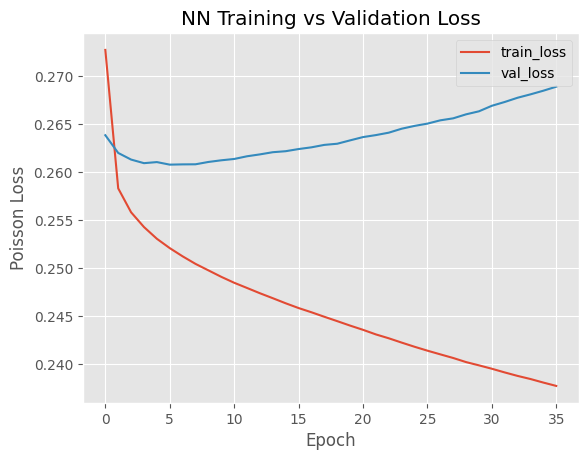

In [51]:
# Plot loss vs. epochs
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('NN Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.legend()
plt.show()

### 3.5 Evaluate Results

In [52]:
# Neural Network Predictions
y_pred_nn_train = nn.predict(X_train_nn).flatten()
y_pred_nn_test = nn.predict(X_test_nn).flatten()

19069/19069 ━━━━━━━━━━━━━━━━━━━━ 9s 453us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step


In [53]:
# Neural Network metrics
mae_nn_train = weighted_mae(y_train, y_pred_nn_train, w_train)
mse_nn_train = weighted_mse(y_train, y_pred_nn_train, w_train)
mae_nn_test  = weighted_mae(y_test, y_pred_nn_test, w_test)
mse_nn_test  = weighted_mse(y_test, y_pred_nn_test, w_test)
deviance_nn_train = poisson_deviance(y_train, y_pred_nn_train, w_train)
deviance_nn_test  = poisson_deviance(y_test,  y_pred_nn_test,  w_test)

# Comparison DataFrame
df_compare = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM Train':   [mae_train, mse_train, deviance_train],
    'GLM Test':    [mae_test, mse_test, deviance_test],
    'GLM+Int Train': [mae_int_train, mse_int_train, deviance_int_train],
    'GLM+Int Test':  [mae_int_test, mse_int_test, deviance_int_test],
    'NN Train': [mae_nn_train, mse_nn_train, deviance_nn_train],
    'NN Test':  [mae_nn_test, mse_nn_test, deviance_nn_test],
})
df_compare.T

,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM Train,0.13819,0.235229,0.728901
GLM Test,0.136234,0.25501,0.709775
GLM+Int Train,0.138262,0.235174,0.727851
GLM+Int Test,0.136298,0.25491,0.708271
NN Train,0.13757,0.23463,0.715988
NN Test,0.136131,0.254994,0.70893
